# Messing Around with Javi's Code


In [3]:
import cheartio
import numpy as np
import meshio

In [4]:
# read in geometry
K = 1e4 # stiffness for spatial multiplier map. (Pa/mm)
xyz, ien, element = cheartio.read_mesh("model")
bfile = cheartio.read_bfile("model")

In [91]:
# NOTE: d to vtu writer: need to input list of D files and then loop through timesteps.
# path_t0 = ["X.D", "P.D"] etc.
# load in systole and diastole data
systole_d = {"X": cheartio.read_dfile("X-241.D"), "P": cheartio.read_dfile("P-241.D"), "spatK": cheartio.read_dfile("spatK-241.D")}
diastole_d = {"X": cheartio.read_dfile("X-1.D"), "P": cheartio.read_dfile("P-1.D"), "spatK": cheartio.read_dfile("spatK-1.D")}

systole_d["X"]

array([[   0.58904283,  -21.95453066,   -8.24663319],
       [   1.19374041,    0.2597431 , -195.39988202],
       [ -13.98077478,   -9.90139934, -194.23335661],
       ...,
       [  16.94887869,    8.14591644, -126.27293024],
       [  11.07942357,   10.20243681,  -13.35996748],
       [  35.5082641 ,   56.32354765,  -55.90098202]], shape=(42140, 3))

In [75]:
displacement = systole_d["X"] - diastole_d["X"]

In [76]:
# find nodes on the outer wall or one of the two flaps
wall_nodes = np.unique(bfile[np.isin(bfile[:, 4], (7,8,9)), 1:4].flatten())
# these are the indices of the nodes on the outer wall or one of the two flaps

In [77]:
moving_nodes = np.abs(np.linalg.norm(displacement, axis=1)) > 1e-7
moving_nodes_idx = np.arange(42140)[moving_nodes]

In [78]:
moving_wall_nodes = np.intersect1d(wall_nodes, moving_nodes_idx)

In [79]:
displacement_main_wall = displacement[moving_wall_nodes]

In [80]:
point_norms = cheartio.read_dfile("norms.D")
point_norms = point_norms[moving_wall_nodes]

In [81]:
pressure_delta = systole_d["P"] - diastole_d["P"]
pressure_delta_main_wall = pressure_delta[moving_wall_nodes]

In [82]:
k = np.zeros(4856)
for i in range(4856):
    k[i] = pressure_delta_main_wall[i] / np.linalg.norm(displacement_main_wall[i])**2 * (displacement_main_wall[i].T @ point_norms[i])

In [83]:
# figuring out how to make a vtu file with the results lol...
# 1) isolate surface nodes on 7,8,9
# 2) find connectivity data for these nodes (I think this is still in B file)
# NOTE: steps one and two will use B file. Need to get correct indexing for K and these nodes...
# 3) set up D matrix with K results. nodes that we don't measure should be set equal to -1? or Nan?
# a) build D array with zeros... then fill in calculated values... and set 0's to Nan?
# could save spatK*K, error, and calculated K in the same file...
wall_bfile_elements = bfile[np.isin(bfile[:, 4], 8), 1:-1] # <- this has original indexing from X file...
# THEREFORE any point data will need to maintain original indexing... oh fuck so I need a lot of zeros lol
stiffness_points = np.zeros(np.shape(xyz)[0])
stiffness_points[moving_wall_nodes] = k
stiffness_points[stiffness_points==0] = np.nan

stiffness_points

array([           nan,            nan, 98772.63438855, ...,
                  nan,            nan,            nan], shape=(42140,))

In [84]:
print("Mean K:", np.mean(k))
print("Std Dev K:", np.std(k))
print("Max K:", np.max(k))
print("Min K:", np.min(k))

# could do a bunch of violin plots here to show the distribution of k values depending on the region...

Mean K: 36489.29839131529
Std Dev K: 25122.261364147707
Max K: 245675.09690370932
Min K: 5735.729782259097


Text(0.5, 1.0, 'Distribution of K values on walls -- Displacement Method')

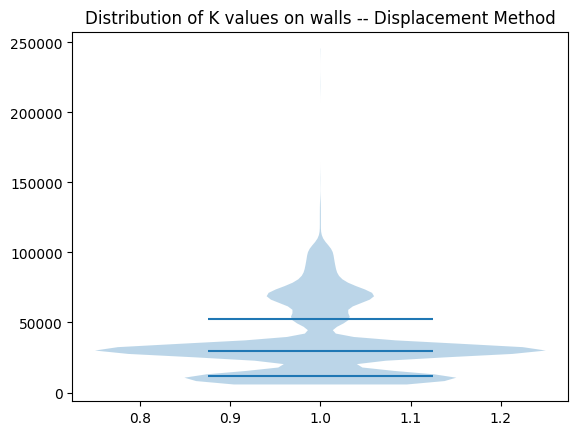

In [85]:
import matplotlib.pyplot as plt
plt.violinplot(k, showextrema=False, quantiles=[0.25, 0.5, 0.75])
plt.title("Distribution of K values on walls -- Displacement Method")

In [86]:
wall_bfile_elements

array([[ 467, 2345, 2334],
       [ 443, 2341, 2336],
       [ 468, 2327, 2335],
       ...,
       [2582, 2581, 2529],
       [3391, 3429, 3331],
       [3331, 3232, 3391]], shape=(10152, 3))

In [95]:
# testing area computation
node1 = xyz[wall_bfile_elements[0, 0]]
node2 = xyz[wall_bfile_elements[0, 1]]
node3 = xyz[wall_bfile_elements[0, 2]]
xyz_sys = systole_d["X"]
xyz_dia = diastole_d["X"]

In [96]:
# beautiful big ass one liner for area calculation
area_sys = 0.5 * np.linalg.norm(np.cross(xyz_sys[wall_bfile_elements[:, 1]] - xyz_sys[wall_bfile_elements[:, 0]], xyz_sys[wall_bfile_elements[:, 2]] - xyz_sys[wall_bfile_elements[:, 0]]), axis=1)
area_dia = 0.5 * np.linalg.norm(np.cross(xyz_dia[wall_bfile_elements[:, 1]] - xyz_dia[wall_bfile_elements[:, 0]], xyz_dia[wall_bfile_elements[:, 2]] - xyz_dia[wall_bfile_elements[:, 0]]), axis=1)
strain = (area_sys-area_dia)/area_dia

In [42]:
meshio.write_points_cells("estimated_stiffness.vtu", xyz, {"triangle": wall_bfile_elements}, point_data={"Stiffness (Pa/mm)": stiffness_points})
meshio.write_points_cells("prescribed_stiffness.vtu", xyz, {"triangle": wall_bfile_elements}, point_data={"Stiffness (Pa/mm)": K*systole_d["spatK"]})
meshio.write_points_cells("stiffness_error.vtu", xyz, {"triangle": wall_bfile_elements}, point_data={"Absolute Error (Pa/mm)": np.abs(K*systole_d["spatK"]-stiffness_points), "Relative Error": np.abs(K*systole_d["spatK"]-stiffness_points)/(K*systole_d["spatK"])})

In [119]:
cells = [("triangle", wall_bfile_elements)]

mesh = meshio.Mesh(xyz, cells, point_data={"Stiffness (Pa/mm)": stiffness_points, "Node Strain": node_strain}, cell_data={"Strain":[strain]})
mesh.write("estimated_stiffness.vtu")

#meshio.write_points_cells("estimated_stiffness.vtu", xyz, cells, , cell_data={"Area (mm^2)": area})

In [98]:
strain

array([-0.03059337,  0.00781376,  0.01554339, ...,  0.01827074,
        0.01837154,  0.01239042], shape=(10152,))

In [115]:
wall_bfile_elements

array([[ 467, 2345, 2334],
       [ 443, 2341, 2336],
       [ 468, 2327, 2335],
       ...,
       [2582, 2581, 2529],
       [3391, 3429, 3331],
       [3331, 3232, 3391]], shape=(10152, 3))

In [ ]:
node_strain = np.zeros(xyz.shape[0])
for i in range(len(wall_bfile_elements.flatten())):
    node_idx = wall_bfile_elements.flatten()[i]
    node_strain[node_idx] = strain[i//3]
    
# YES or wait... should I assemble area THEN calculate strain? don't thnk it matters

In [109]:
node_strain = np.zeros(xyz.shape[0])
node_strain[wall_bfile_elements] = strain[wall_bfile_elements]

In [117]:
node_strain[3331] # WAIT shouldn't I add... some indices are repeated here right?

np.float64(0.01239041831596971)

In [118]:
np.sum(node_strain)

np.float64(68.09686294197272)

In [ ]:
node_stiffness = pressure_delta